In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import bz2 # To open zipped files
import re # regular expressions
import os
import gc

from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier


for dirname, _, filenames in os.walk('/Users/richardrflsngmail.com/Downloads/archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


print(os.listdir("/Users/richardrflsngmail.com/Downloads/archive"))

/Users/richardrflsngmail.com/Downloads/archive/.DS_Store
/Users/richardrflsngmail.com/Downloads/archive/test.ft.txt.bz2
/Users/richardrflsngmail.com/Downloads/archive/test.ft.txt
/Users/richardrflsngmail.com/Downloads/archive/train.ft.txt.bz2
['.DS_Store', 'test.ft.txt.bz2', 'test.ft.txt', 'train.ft.txt.bz2']


In [2]:
train_file = bz2.BZ2File('/Users/richardrflsngmail.com/Downloads/archive/train.ft.txt.bz2')
test_file = bz2.BZ2File('/Users/richardrflsngmail.com/Downloads/archive/test.ft.txt.bz2')

In [3]:
train_file_lines = train_file.readlines()
test_file_lines = test_file.readlines()

In [4]:
# clean the older variables
del train_file, test_file
gc.collect()

0

# DATA PREPARATION and CLEANING

In [5]:
train_file_lines = [x.decode('utf-8') for x in train_file_lines]
test_file_lines = [x.decode('utf-8') for x in test_file_lines]

In [6]:
print(type(train_file_lines), type(test_file_lines), "\n")

print("Train Data Volume:", len(train_file_lines), "\n")
print("Test Data Volume:", len(test_file_lines), "\n\n")

print("Demo: ", "\n")
for x in train_file_lines[:5]:
    print(x, "\n")

<class 'list'> <class 'list'> 

Train Data Volume: 3600000 

Test Data Volume: 400000 


Demo:  

__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
 

__label__2 The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, t

# EXTRACTING LABELS from THE DATA

In [7]:
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
test_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in test_file_lines]

In [8]:
train_labels[0]

1

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(train_labels)
plt.title('Train Labels distribution')

In [ ]:
sns.countplot(test_labels)
plt.title('Test Labels distribution')

# EXTRACTING REVIEWS from THE DATA

In [9]:
train_sentences = [x.split(' ', 1)[1][:-1] for x in train_file_lines]
test_sentences = [x.split(' ', 1)[1][:-1] for x in test_file_lines]

In [10]:
train_sentences[0]

'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [11]:
train_sentences_size = list(map(lambda x: len(x.split()), train_sentences))

sns.histplot(train_sentences_size, kde=True)
plt.xlabel("#words in reviews")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution in Reviews")


KeyboardInterrupt



In [11]:
train_label_len = pd.DataFrame({"labels": train_labels, "len": train_sentences_size})
train_label_len.head()

NameError: name 'train_sentences_size' is not defined

# DIVIDE IT by SENTIMENT and CALCULATE AVERAGE VALUES

In [13]:
neg_mean_len = train_label_len.groupby('labels')['len'].mean().values[0]
pos_mean_len = train_label_len.groupby('labels')['len'].mean().values[1]

print(f"Negative mean length: {neg_mean_len:.2f}")
print(f"Positive mean length: {pos_mean_len:.2f}")
print(f"Mean Difference: {neg_mean_len-pos_mean_len:.2f}")

sns.catplot(x='labels', y='len', data=train_label_len, kind='box')
plt.xlabel("labels (0->negative, 1->positive)")
plt.ylabel("#words in reviews")
plt.title("Review Size Categorization")

# CLEAN URLs

In [12]:
for i in range(len(train_sentences)):
    if 'www.' in train_sentences[i] or 'http:' in train_sentences[i] or 'https:' in train_sentences[i] or '.com' in train_sentences[i]:
        train_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", train_sentences[i])

for i in range(len(test_sentences)):
    if 'www.' in test_sentences[i] or 'http:' in test_sentences[i] or 'https:' in test_sentences[i] or '.com' in test_sentences[i]:
        test_sentences[i] = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", "<url>", test_sentences[i])

In [13]:
list(filter(lambda x: '<url>' in x, train_sentences))[0]

"Bad Deal!!: I ordered this DVD and received a substitute I never received the DVD I ordered from Importcds (the Vendor). I contacted them and did not recieve any feedback. I can't rate a DVD I have never seen. I didn't bother to send it back because it would have cost me more that I orginally paid for it. In the future I will watch for the name of the person and/or persons I am buying from. I thought they were a good company. I understand a simple mistake but, to not get a response at all is not good businees sense. I spend hundreds of dollars a month on <url> building my DVD collection. I guess I will be more careful in the future."

In [14]:
del train_file_lines, test_file_lines
gc.collect()

534

# LOWERCASING, TOKENIZATION, STEMMING and LEMMATIZATION

In [15]:
import nltk
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

nltk.data.path.append('/Users/richardrflsngmail.com/Downloads/archive')
nltk.download('averaged_perceptron_tagger')
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_sent(text): 
    # Text input is string, returns lowercased strings.
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(text))]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/richardrflsngmail.com/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/richardrflsngmail.com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/richardrflsngmail.com/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/richardrflsngmail.com/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
lemmatize_sent('He is WALKING walking to school')

['he', 'be', 'walking', 'walk', 'to', 'school']

# STOPWORDS

In [18]:
# Stopwords from stopwords-json
stopwords_json = {"en":["a","a's","able","about","above","according","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost",
                        "alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways",
                        "anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be",
                        "became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between",
                        "beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com",
                        "come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d",
                        "definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight",
                        "either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example",
                        "except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get",
                        "gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having",
                        "he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how",
                        "howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar",
                        "instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later",
                        "latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean",
                        "meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither",
                        "never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often",
                        "oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own",
                        "p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re",
                        "really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see",
                        "seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since",
                        "six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still",
                        "sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves",
                        "then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third",
                        "this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try",
                        "trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v",
                        "value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what",
                        "what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither",
                        "who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you",
                        "you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]}
stopwords_json_en = set(stopwords_json['en'])
stopwords_nltk_en = set(stopwords.words('english'))
stopwords_punct = set(punctuation)
# Combine the stopwords. Its a lot longer so I'm not printing it out...
stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en, stopwords_punct)

# CLEAN DIGITS

In [19]:
def preprocess_text(text):
    # Input: str, i.e. document/sentence
    # Output: list(str) , i.e. list of lemmas
    return [word for word in lemmatize_sent(text) 
            if word not in stoplist_combined
            and not word.isdigit()]

In [20]:
train_sentences[10]

"The Worst!: A complete waste of time. Typographical errors, poor grammar, and a totally pathetic plot add up to absolutely nothing. I'm embarrassed for this author and very disappointed I actually paid for this book."

In [21]:
preprocess_text(train_sentences[10])

['bad',
 'complete',
 'waste',
 'time',
 'typographical',
 'error',
 'poor',
 'grammar',
 'totally',
 'pathetic',
 'plot',
 'add',
 'absolutely',
 "'m",
 'embarrassed',
 'author',
 'disappointed',
 'pay',
 'book']

# WORD EMBEDDINGS, VECTORIZATION with sklearn

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer=preprocess_text)

In [23]:
train_set = count_vect.fit_transform(train_sentences[:10000])

In [24]:
train_set.toarray().shape

(10000, 32640)

In [25]:
test_set = count_vect.transform(test_sentences[:1000])

<Axes: title={'center': 'Most Frequent Words'}, xlabel='word'>

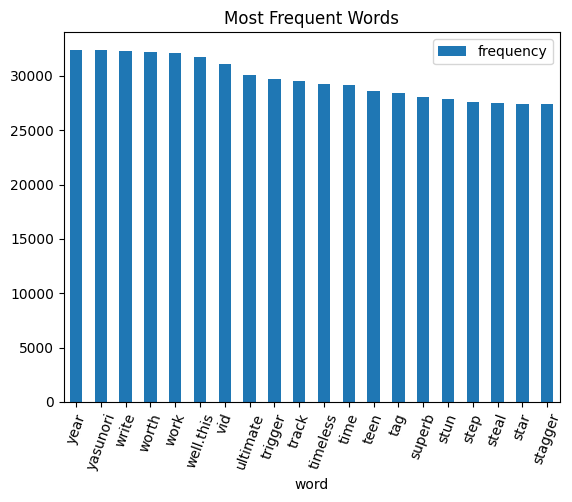

In [26]:
most_freq_words = pd.DataFrame(count_vect.vocabulary_.items(), columns=['word', 'frequency'])[:100].sort_values(ascending=False, by = "frequency")[:20]
most_freq_words.plot.bar(x="word", y="frequency", rot=70, title="Most Frequent Words")

# METHODS: MULTINOMIAL NALVE BAYES CLASSIFIER in sklearn

In [27]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [28]:
clf.fit(train_set, train_labels[:10000])

MultinomialNB()

In [29]:
from sklearn.metrics import accuracy_score

# To predict our tags (i.e. whether requesters get their pizza), 
# we feed the vectorized `test_set` to .predict()
predictions_valid = clf.predict(test_set)

print('Amazon Sentiment Analysis Accuracy = {}'.format(
        accuracy_score(predictions_valid, test_labels[:1000]) * 100)
    )

Amazon Sentiment Analysis Accuracy = 82.69999999999999


# FEATURE IMPORTANCE

In [30]:
def important_features(vectorizer,classifier,n=40):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names_out()

    topn_class1 = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]
    topn_class2 = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]

    class1_frequency_dict = {}
    class2_frequency_dict = {}
    
    for coef, feat in topn_class1:
        class1_frequency_dict.update( {feat : coef} )

    for coef, feat in topn_class2:
        class2_frequency_dict.update( {feat : coef} )

    return (class1_frequency_dict, class2_frequency_dict)

In [31]:
neg_frequency_dict, pos_frequency_dict = important_features(count_vect, clf)

In [32]:
neg_feature_freq = pd.DataFrame(neg_frequency_dict.items(), columns = ["feature_word", "frequency"])  
pos_feature_freq = pd.DataFrame(pos_frequency_dict.items(), columns = ["feature_word", "frequency"]) 

<Axes: title={'center': 'Important Negative Features(words)'}, xlabel='feature_word'>

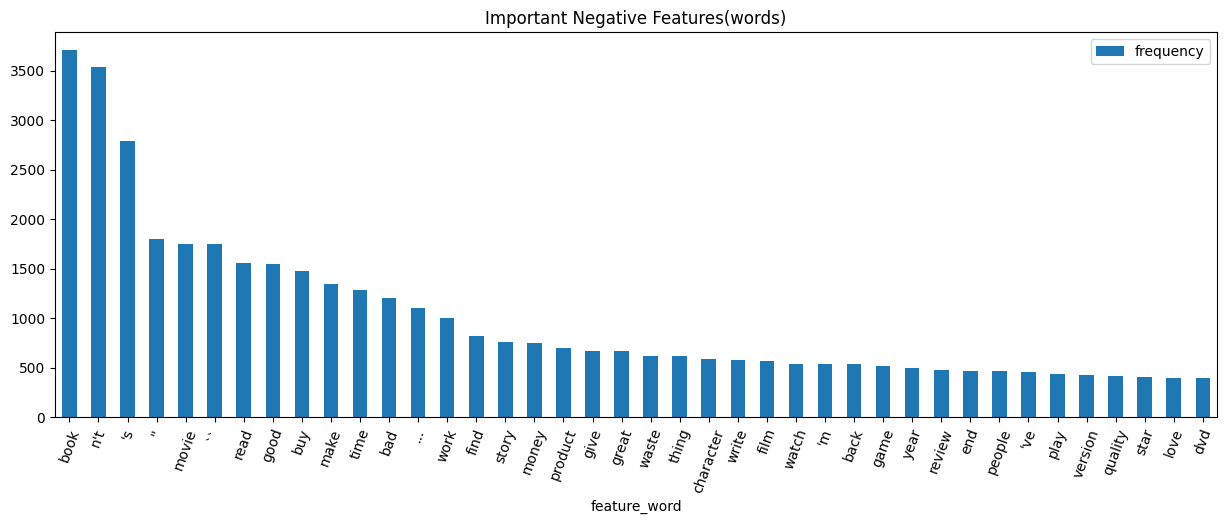

In [33]:
neg_feature_freq.plot.bar(x="feature_word", y="frequency", rot=70, figsize=(15, 5), title="Important Negative Features(words)")

<Axes: title={'center': 'Important Positive Features(words)'}, xlabel='feature_word'>

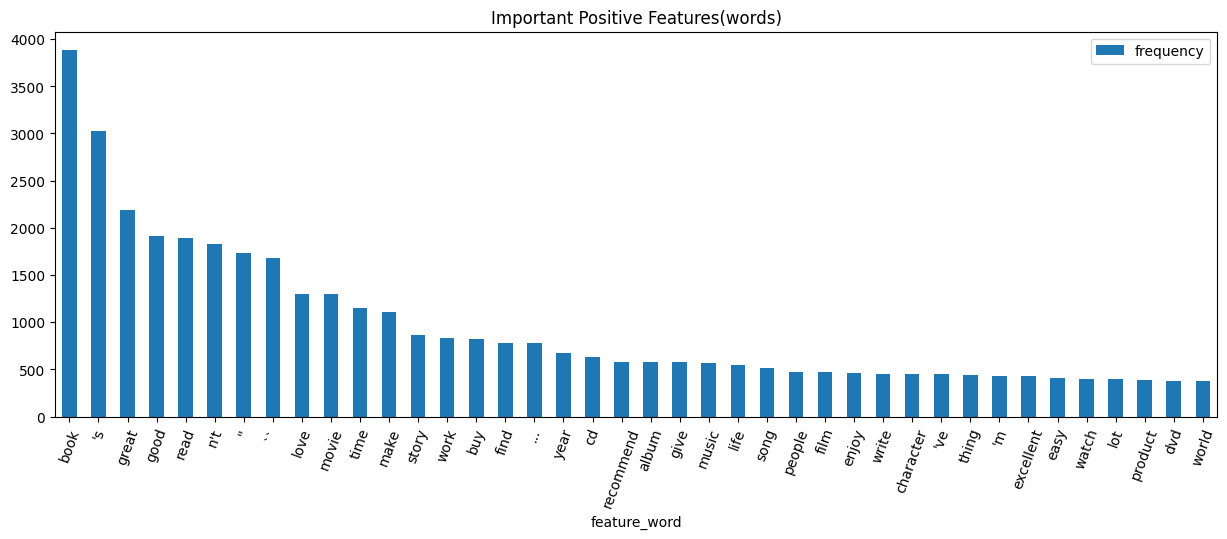

In [34]:
pos_feature_freq.plot.bar(x="feature_word", y="frequency", rot=70, figsize=(15, 5), title="Important Positive Features(words)")